## Nagel-Schrankenberg Cellular Automata Simulation

In [2]:
import numpy as np 

class TrafficSimulation:
    def __init__(self, length = 100, density = 0.5, maxv = 5, pslow = 0.5):
        """
        length = length of road (it wraps around)
        density = length/cars
        maxv = max velocity any (and all) cars can go.
        pslow = probability of slowing down (default 0.5)
        """

        self.length = length
        self.density = density
        self.maxv = maxv
        self.pslow = pslow
    
        self.state = [maxv if i <= length*density else -1 for i in range(length)]
        np.random.shuffle(self.state)
        
    def display(self):
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        
    def calculate(self):
        for i, v in enumerate(self.state):
            if v >= 0:
                d = 1
                # find distance to next car, d
                while self.state[(i + d) % self.length] == -1: d += 1
                
                # adjust speed - if distance to next car > speed, +1 velocity. If less, slow down to d-1
                self.state[i] = min(self.state[i] + 1, self.maxv) if d > v + 1 else (d-1)
                
                # decrease speed by 1 with probability pslow
                if (self.state[i] > 0 and np.random.random() < self.pslow): self.state[i] -= 1
                   
                    
    def update(self):
        newstate = [-1] * self.length

        for i, v in enumerate(self.state):
            if v >= 0: 
                newstate[(i + v) % self.length] = v
        
        self.state = newstate
        
    def run(self, n, verbose = False):
        for i in range(n):
            self.calculate()
            if verbose: self.display()
            self.update()
            

In [3]:
np.random.seed(seed = 20)
traffic = TrafficSimulation(length = 100, density = 0.03, maxv = 5, pslow = 0.5)
traffic.run(30, verbose = True)

..5.....4.................4..............................................5..........................
.......3....5.................4...............................................5.....................
..........3......5................4................................................5................
.............4........5...............4.................................................5...........
.................5.........4..............5..................................................5......
......................5........5...............5..................................................4.
..5........................5........5...............4...............................................
.......4........................4........4..............4...........................................
...........4........................5........5..............5.......................................
...............4.........................4........4..............4.........................

In [4]:
np.random.seed(seed = 69)
traffic = TrafficSimulation(length = 100, density = 0.1, maxv = 5, pslow = 0.5)
traffic.run(30, verbose = True)

.....4......4.........3...5.....4.....04......5................................2...5.......5........
.........4......5........4.....4....0.1....5.......4.............................2......4.......5...
.4...........5.......5.......4.....00..1........5......4...........................3........4.......
.....5............4.......4......1.00...2............4.....4..........................3.........5...
.5........5...........5.......2...001.....3..............4.....4.........................3..........
......5........4...........3....1.01.2.......4...............5.....5........................4.......
...........4.......4..........1..00.2..2.........4................5.....4.......................5...
.4.............4.......4.......0.01...2..2...........5.................3....5.......................
.....5.............5.......2...1.1.1....2..3..............5...............4......4..................
..........5.............4....2..0.0.2.....3...4................5..............5......4.....

## Implementing "Flow"

In [5]:
class FlowSimulation(TrafficSimulation):
    def update(self):
        newstate = [-1] * self.length
        
        flow = 0

        for i, v in enumerate(self.state):
            if v >= 0: 
                newstate[(i + v) % self.length] = v
            if i + v > self.length:
                flow += 1
        
        self.state = newstate
        
        return flow
        
    def run(self, n, verbose = False):
        flows = []
        for i in range(n):
            self.calculate()
            if verbose: self.display()
            flows.append(self.update())
        return np.mean(flows)
    

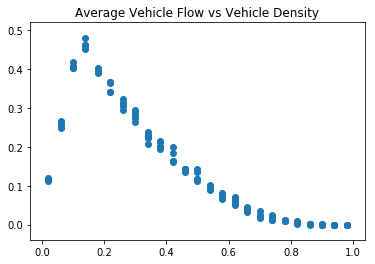

In [174]:
import matplotlib.pyplot as plt
%matplotlib inline

densities = np.arange(0.02, 1, 0.04).repeat(5)
flow = [FlowSimulation(100, d, 5, .2).run(n=1000) for d in densities]


plt.scatter(densities, flow)
plt.title("Average Vehicle Flow vs Vehicle Density")
plt.show()

## Always in the Middle Rule

In [51]:
class MiddleRuleSimulation(FlowSimulation):
    def calculate(self):
        
        for i, v in enumerate(self.state):
            if v >= 0:
                d_front, d_back = 1,1

                # find distance to the front and to the back
                while self.state[(i + d_front) % self.length] == -1: d_front += 1
                while self.state[(i - d_back) % self.length] == -1: d_back += 1

                # if distance to front greater than to back, accelerate 1. If less, decelerate one.
                self.state[i] = min(v + 1, self.maxv, d_front - 1) if (d_front + 1 > d_back) else min(max(v - 1, 0), d_front - 1)

                # decrease speed by 1 with probability pslow
                if (self.state[i] > 0 and np.random.random() < self.pslow): self.state[i] -= 1

In [59]:

middle = MiddleRuleSimulation(length = 100, density = 0.1, maxv = 5, pslow = 0.5)
middle.run(30, verbose = True)

4.............................1..04.......4...............1..3...5........4.......4..............2..
....5..........................0.0....5.......5............0....4.....4.......5.......4............0
.........4.....................0.0.........5.......5.......0........2.....4........4......5........1
1............5.................0.1..............3.......2..0..........0.......4........4.......3....
.1................3............0..2................1......00..........1...........3........4......2.
1.1..................1.........0....2...............0.....01...........2.............1.........2....
.0.1..................0........1......2.............0.....0.1............2............2..........0..
.1..1.................0.........1.......3...........0.....0..1.............2............0........0..
..2..1................0..........2.........4........0.....1...2..............0..........1........0..
....0.1...............0............2...........3....1......1....2............0...........0.

0.03333333333333333

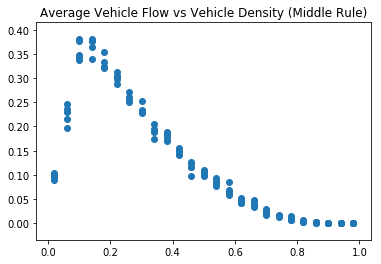

In [175]:
middleflow = [MiddleRuleSimulation(100, d, 5, .2).run(n=1000) for d in densities]

plt.scatter(densities, middleflow)
plt.title("Average Vehicle Flow vs Vehicle Density (Middle Rule)")
plt.show()

## MultiLane Highway

In [228]:
class MultiLaneSimulation:
    def __init__(self, length = 100, density = 0.1, maxv = 5, pslow = 0.5, nlanes = 2):
        self.length = length
        self.density = density
        self.maxv = maxv
        self.pslow = pslow
        self.nlanes = nlanes
        
        self.state = [maxv if i <= length*nlanes*density else -1 for i in range(length*nlanes)]
        np.random.shuffle(self.state)
        self.state = np.reshape(self.state,(nlanes, length))
        
    def display(self):
        print('\n'.join(''.join('.' if x == -1 else str(x) for x in row) for row in self.state) + "\n")
        
    def switch(self):
        for j in range(len(self.state)):
            for i, v in enumerate(self.state[j]):
                if v >= 0:
                    l = 1
                    
                    # Check distance in front. No need to switch if there is space in currently lane
                    while self.state[j, (i + l) % self.length] == -1 and l <= v + 1: l += 1
                    if l >= v+1: continue
                        
                    # Check if left lane, then right lane is suitable for a switch. 
                    for lane in (j-1, j+1):
                        # Lane not suitable if it doesn't exist,
                        if lane < 0 or lane + 1 > self.nlanes: continue
                        
                        # lane is not suitable if not enough distance in front or at the back
                        d_front, d_back = 0, 0 
                        while self.state[lane, (i + d_front) % self.length] == -1 and d_front <= v + 1: d_front += 1
                        while self.state[lane, (i - d_back) % self.length] == -1 and d_back <= self.maxv: d_back += 1
                        if d_front < v or d_back < self.maxv: continue

                        #print(f"switching vehicle {v} at {(j,i)} to {(lane,i)}")
                        self.state[j, i], self.state[lane, i] = -1, v
                        break
    
    def calculate(self):
        for j in range(len(self.state)):
            for i, v in enumerate(self.state[j]):
                if v >= 0:
                    d = 1
                    while self.state[j, (i + d) % self.length] == -1: d += 1

                    self.state[j, i] = min(self.state[j, i] + 1, self.maxv) if d > v + 1 else (d - 1)

                    if (self.state[j, i] > 0 and np.random.random() < self.pslow): self.state[j, i] -= 1
                        
    def update(self):
        newstate = -np.ones((self.nlanes, self.length), int)
        
        flow = 0
        
        for j in range(self.nlanes):
            for i, v in enumerate(self.state[j]):
                if i + v > self.length:
                    flow += 1
                if v >= 0:
                    newstate[j,(i + v) % self.length] = v
                    
        self.state = newstate
        return flow/self.nlanes
    
    def run(self, n, verbose = False, switching = True):
        flows = []
        for i in range(n):
            if switching: self.switch()
            self.calculate()
            if verbose: self.display()
            flows.append(self.update())
        return np.mean(flows)

In [229]:
np.random.seed(13)
multi = MultiLaneSimulation(pslow = 0)
multi.run(10, verbose = True, switching = True)

.......................5...........1.5..........3...2..05................4....5.....................
....5.....5......5.....5.........5............05........5................3...5......5...........5...

............................5.......2.....5........2..01.....5...............5.....5................
.5.......5.....5......5.....5.........5.......1.....5........5..............4.....5......5..........

.................................4....3........5......1.2.........5...............5.....5...........
......5.......5.....5......5.....5.........3...2.....3...5........5.............5......5......5.....

.....................................3...4....4.....2..2..3............5...............5.....5......
...........5.......5.....5......5.....5..........3......4.....5........5.............5......5......5

........................................4....4....3...2..3...4..............5...............5.....5.
....5...........5.......5.....5......5.....5........4.......5......5........5..........

0.35

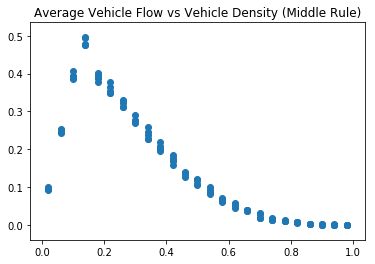

In [227]:
multiflow = [MultiLaneSimulation(100, d, 5, .2).run(n=1000) for d in densities]

plt.scatter(densities, multiflow)
plt.title("Average Vehicle Flow vs Vehicle Density (Middle Rule)")
plt.show()

### 5.1 Preclasswork Questions

In [268]:
print("Question 1")
q = MultiLaneSimulation(length = 19, pslow = 0); q.state = -np.ones((2,19),int)
q.state[1,(7,11)] = 2
q.display(); q.run(2, verbose = True)

print("Question 2")
q = MultiLaneSimulation(length = 19, pslow = 0); q.state = -np.ones((2,19),int)
q.state[1,(8,11)] = 2
q.display(); q.run(2, verbose = True)

print("Question 3")
q = MultiLaneSimulation(length = 19, pslow = 0); q.state = -np.ones((2,19),int)
q.state[0,5] = 1; q.state[1,(8,11)] = 2
q.display(); q.run(2, verbose = True)

print("Question 4")
q = MultiLaneSimulation(length = 19, pslow = 0); q.state = -np.ones((2,19),int)
q.state[1,(9,11)] = 2
q.display(); q.run(2, verbose = True)

print("Question 5")
q = MultiLaneSimulation(length = 19, pslow = 0); q.state = -np.ones((2,19),int)
q.state[0,11] = 5; q.state[1,(9,11)] = 2
q.display(); q.run(2, verbose = True)

print("Question 6")
q = MultiLaneSimulation(length = 19, pslow = 0); q.state = -np.ones((2,19),int)
q.state[(0,1),3] = 5; q.state[1,7:10] = (1,0,0); q.state[(0,1),12] = (3,1); q.state[1,15] = 2
q.display(); q.run(2, verbose = True)


Question 1
...................
.......2...2.......

...................
.......3...3.......

...................
..........3...4....

Question 2
...................
........2..2.......

...................
........2..3.......

...................
..........3...4....

Question 3
.....1.............
........2..2.......

.....2.............
........2..3.......

.......3...........
..........3...4....

Question 4
...................
.........2.2.......

.........3.........
...........3.......

............4......
..............4....

Question 5
...........5.......
.........2.2.......

.........1.5.......
...........3.......

..........2.....5..
..............4....

Question 6
...5........3......
...5...100..1..2...

...5........4......
...3...001..2..3...

........5.......5..
......001.2...3...4



0.5